## Import Modules

In [20]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from textwrap import wrap
import warnings
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [22]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [23]:
image_path='/kaggle/input/flickr8k/Images'
data=pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [24]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

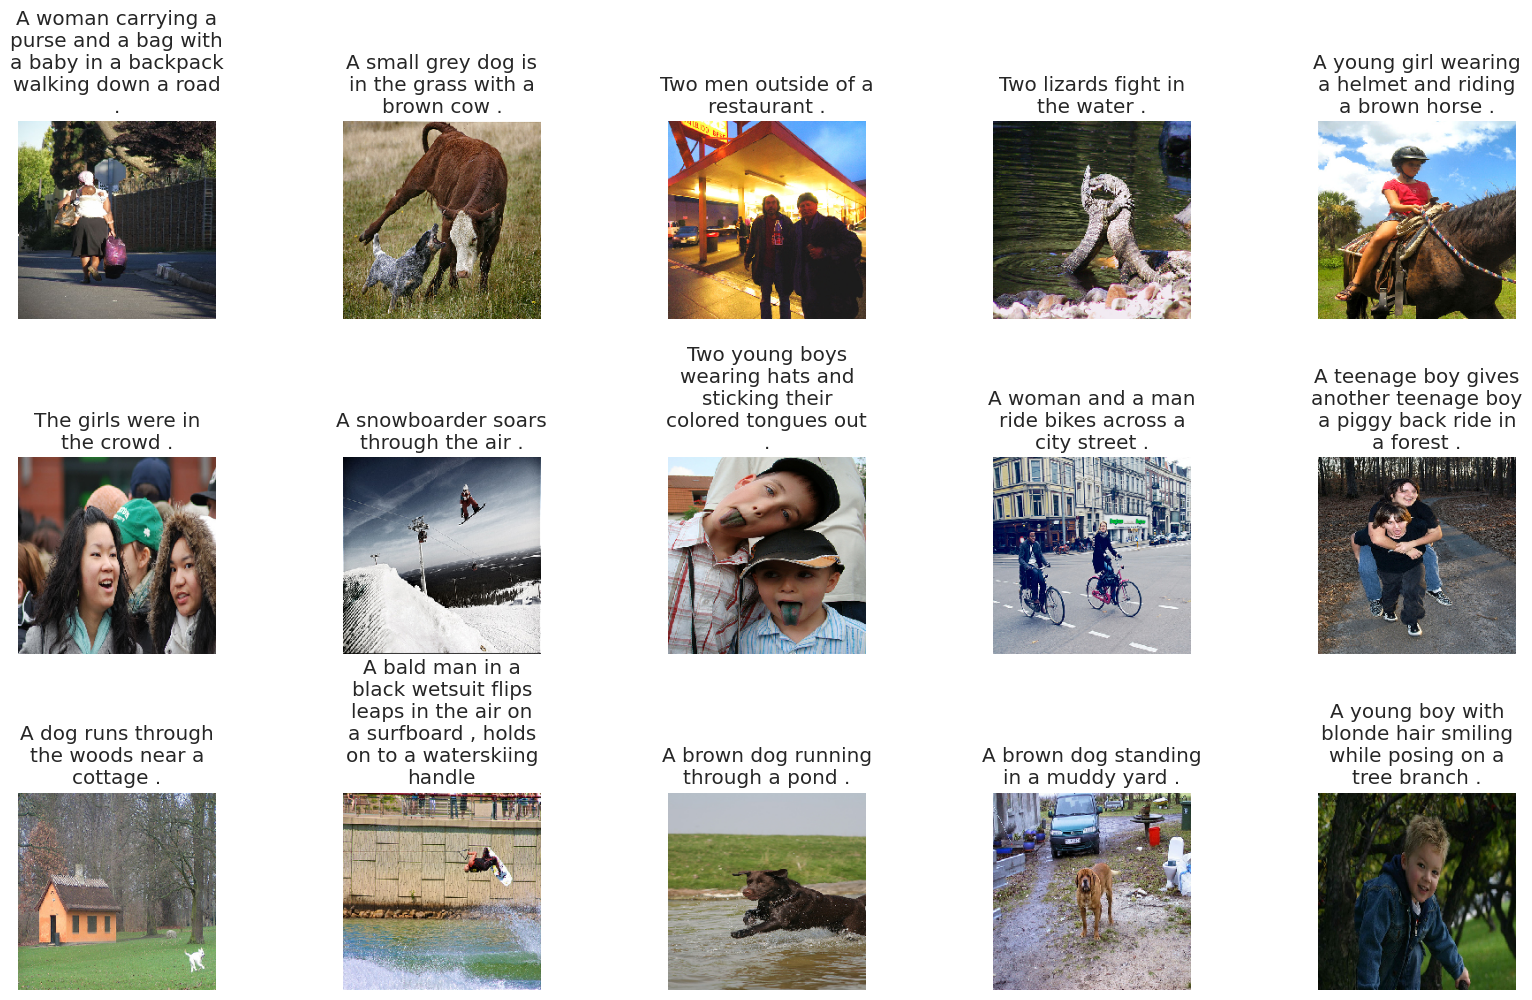

In [25]:
display_images(data.sample(15))

## Image Feature Extraction

In [26]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

## Preprocess Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # taking one caption at a time
            caption = captions[i]
            
            caption = caption.lower()
             
            caption = caption.replace('[^A-Za-z]', '')
            
            caption = caption.replace('\s+', ' ')
            
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# data generator to get data in batch 
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [24]:
# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 69s 304ms/step - loss: 2.1782


In [25]:
# save the model
model.save(WORKING_DIR+'/Final_model.h5')

## Captions for the Image

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.524316
BLEU-2: 0.299997


## Visualize the Results

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black and white dog catches toy in midair endseq
startseq dog and tennis ball endseq
startseq "a dog is jumping to catch object thrown at it endseq
startseq dog leaps while chasing tennis ball through grassy field endseq
startseq multicolor dog jumping to catch tennis ball in grassy field endseq
--------------------Predicted--------------------
startseq multicolor dog catches tennis ball in its mouth endseq


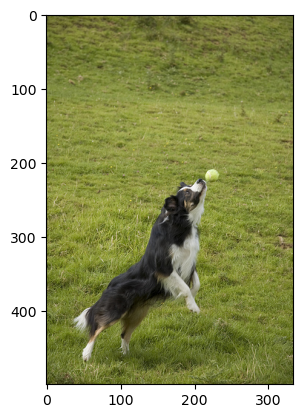

In [43]:
generate_caption("1072153132_53d2bb1b60.jpg")

---------------------Actual---------------------
startseq boy cleans the bubbles off his face endseq
startseq boy covered in suds has his face wiped clean endseq
startseq boy is covered in bubbles endseq
startseq child covered in foam is climbing on black inflatable ramp endseq
startseq person covered in soapy water is getting cleaned off endseq
--------------------Predicted--------------------
startseq small boy cleans up bubbles covered in water endseq


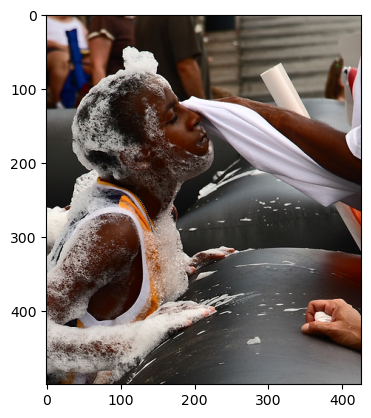

In [42]:
generate_caption("1075881101_d55c46bece.jpg")

---------------------Actual---------------------
startseq man and woman pose for the camera while another man looks on endseq
startseq man is holding the hand of woman up to his mouth in front of some buildings while another man looks on endseq
startseq multiracial couple posing for picture endseq
startseq "asian man and blond woman holding hands outdoors man in background watches ." endseq
startseq guy in blue shirt biting hand of girl in black striped jacket while another guy watches endseq
--------------------Predicted--------------------
startseq two girls are posing for picture with their arm around their shoulders endseq


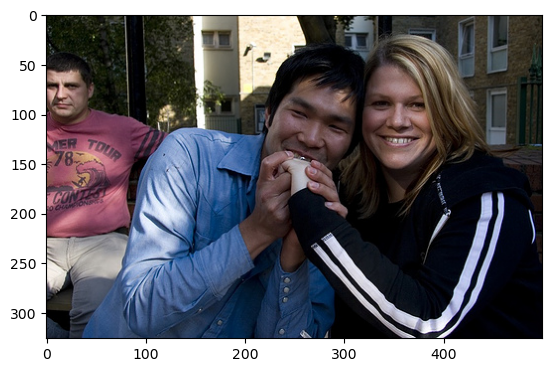

In [41]:
generate_caption("1042590306_95dea0916c.jpg")

## Test with Real Image

In [33]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [34]:
image_path = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq woman sits on the back of garden endseq'

In [35]:
image_path = '/kaggle/input/test-data/Image1.png'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq baseball player pitches the ball endseq'

In [36]:
image_path = '/kaggle/input/test-data/Image2.png'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq two dogs are playing on the edge of the backdrop of the backdrop endseq'

In [38]:
image_path = '/kaggle/input/test-data/Image3.png'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq woman in white coat is drilling on the street endseq'